# Bayesian CNN Implementation

The objective of this code is to compare both a "conventional" CNN with a Bayesian version of it. Therefore, to spare computational power, the networks are not that complex, not being able to produce "satisfactory" results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import splitfolders
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
from torchvision.utils import make_grid
import torch.nn.functional as F

GPU enabling and checking

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(tf.config.list_physical_devices('GPU'))

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device being used : " + str(device))

2.8.0
Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device being used : cuda:0


Define Paths

In [3]:
path_dataset = "flowers"
path_split = "tvt_flowers"
path_models = "models"
path_data_plots = "data_plots"
path_plots = "plots"
path_models = "models"

training_data_path = os.path.join(path_split,"train")
training_aug_data_path = os.path.join(path_split,"train_aug")
validation_data_path = os.path.join(path_split,"val")
testing_data_path =os.path.join(path_split,"test")
train_less_aug_path = os.path.join(path_split,"train_less_aug")

Define batch size and image size, the image size was downscaled to 32x32 because the original script was applied to CIFAR10, this also reduces both the computational power and makes a simpler network achieve better results. Rather than inputting 220x220 images.


In [4]:
bs = 32
nw = 4

img_height = 220
img_width = 220

transformation = transforms.Compose([   transforms.Resize((img_height, img_width)),
                                        transforms.ToTensor()])                                                        

training_ds = ImageFolder(training_data_path, transform = transformation)
val_ds = ImageFolder(validation_data_path, transform = transformation)
test_ds = ImageFolder(testing_data_path, transform = transformation)

Put the data in a list - used as before the train_test_split function

In [5]:
print("Transfering data to a different array")

#Val dataset
val_ds, discard = train_test_split(val_ds, test_size=1)
val_ds.append(discard[0])
print("Finished copying validation data")

#No aug dataset
training_ds, discard = train_test_split(training_ds, test_size=1)
training_ds.append(discard[0])
print("Finished copying training data not augmented")

#Test dataset
test_ds, discard = train_test_split(test_ds, test_size=1)
test_ds.append(discard[0])
print("Finished copying test data")

Transfering data to a different array
Finished copying validation data
Finished copying training data not augmented
Finished copying test data


Put the data in numpy arrays

In [6]:
datasets = [training_ds, val_ds, test_ds]

x_train = np.empty((len(training_ds),img_height,img_width,3)) 
y_train = np.empty((len(training_ds)), dtype=int)
x_val = np.empty((len(val_ds),img_height,img_width,3))
y_val = np.empty((len(val_ds)), dtype=int)
x_test = np.empty((len(test_ds),img_height,img_width,3))
y_test = np.empty((len(test_ds)), dtype=int)

for ds in datasets:
    for i,data_label in enumerate(ds):
        data, label = data_label
        if ds == training_ds:
            x_train[i] = data.numpy().transpose(1,2,0)
            y_train[i] = label
        elif ds == val_ds:
            x_val[i] = data.numpy().transpose(1,2,0)
            y_val[i] = label
        else:
            x_test[i] = data.numpy().transpose(1,2,0)
            y_test[i] = label



Encode the labels in a one hot encode style

In [7]:
def one_hot_encode(array):
    aux = np.zeros((array.size, array.max()+1))
    aux[np.arange(array.size),array] = 1
    return aux

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

From here the code is really similar from the one in the given script. However, the network was augmented since the results obtained with the initial NN were really poor and did not offer many conclusions so the network was changed into a ResNet38

#### "Conventional" NN - ResNet34

In [8]:
#https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [9]:
model = ResNet34((img_height,img_width,3), 5)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [43]:
bs = 32
epochs =  40

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=bs,
    epochs=epochs,
    validation_data=(x_val,y_val),
    shuffle=True,
    verbose=1
)

Epoch 1/40
98/98 [==============================] - 16s 160ms/step - loss: 0.8361 - accuracy: 0.6739 - val_loss: 1.1112 - val_accuracy: 0.5860
Epoch 2/40
98/98 [==============================] - 16s 160ms/step - loss: 0.8215 - accuracy: 0.6871 - val_loss: 0.9299 - val_accuracy: 0.6531
Epoch 3/40
98/98 [==============================] - 16s 161ms/step - loss: 0.7740 - accuracy: 0.6993 - val_loss: 1.0112 - val_accuracy: 0.6152
Epoch 4/40
98/98 [==============================] - 16s 162ms/step - loss: 0.7545 - accuracy: 0.7070 - val_loss: 0.9495 - val_accuracy: 0.6122
Epoch 5/40
98/98 [==============================] - 16s 163ms/step - loss: 0.7819 - accuracy: 0.6858 - val_loss: 1.3655 - val_accuracy: 0.4490
Epoch 6/40
98/98 [==============================] - 16s 164ms/step - loss: 0.7809 - accuracy: 0.6954 - val_loss: 1.0561 - val_accuracy: 0.6006
Epoch 7/40
98/98 [==============================] - 16s 164ms/step - loss: 0.7389 - accuracy: 0.7180 - val_loss: 1.3866 - val_accuracy: 0.5044

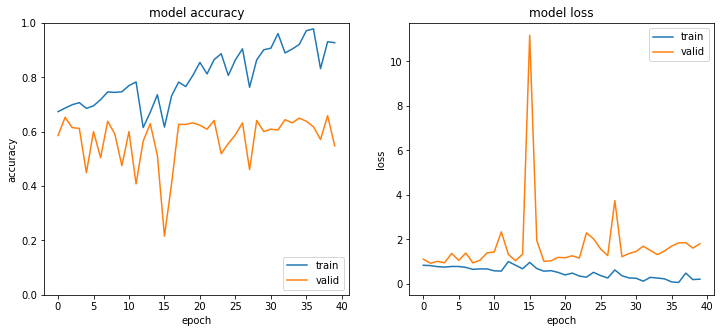

In [44]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [46]:
model.save(os.path.join('models','keras_cnn_resnet38'))

INFO:tensorflow:Assets written to: models\keras_cnn_resnet38\assets


In [45]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
28/28 [==============================] - 1s 46ms/step - loss: 1.7841 - accuracy: 0.5795
test loss, test acc: [1.7841399908065796, 0.5794931054115295]


#### Bayesian CNN - Variational Inference - ResNet34

In [17]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)

def BNN_ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tfp.layers.DenseFlipout(512, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn)(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [18]:
model_vi = BNN_ResNet34((img_height,img_width,3), 5)

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_vi.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 226, 226, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_108 (Conv2D)            (None, 113, 113, 64  9472        ['zero_padding2d_4[0][0]']       
                                )                                                          

D:\miniconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
D:\miniconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


                                                                                                  
 activation_110 (Activation)    (None, 29, 29, 128)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_121 (Conv2D)            (None, 29, 29, 128)  147584      ['activation_110[0][0]']         
                                                                                                  
 batch_normalization_111 (Batch  (None, 29, 29, 128)  512        ['conv2d_121[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_53 (Add)                   (None, 29, 29, 128)  0           ['batch_normalization_111[0][0]',
                                                                  'activation_109[0][0]']         
          

In the next cell you can see that you get a different prediction for the same image, when you predict it multilple times. Everytime you sample each weight with the corresponding parameters and the prediction changes a bit. 

In [32]:
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])

[3.1432223e-09 5.6051696e-03 9.8852390e-01 5.8428906e-03 2.8037060e-05]
[1.9655256e-07 7.2827635e-05 3.1259553e-06 9.9992383e-01 1.4299208e-10]
[1.9840574e-05 5.2229001e-04 9.9487019e-01 4.5741010e-03 1.3612060e-05]
[1.9741958e-06 3.2460528e-05 3.8842736e-06 9.9996161e-01 6.5970673e-11]
[1.3340430e-04 3.9234357e-03 8.3916205e-01 1.5676755e-01 1.3485145e-05]


In [19]:
#Training
#Note that we trained longer for the VI methods, than for the MC Bayes
#Also, each training data is predicted "50" times, in each time the network has different weights and biases
#In the output there is an error but that is because we ended up not saving the files, but the model still successfuly trained

epochs = 300
batch_size = 32

from  tensorflow.keras.callbacks import ModelCheckpoint

fp = "vi_128_lrdefault_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
cb = ModelCheckpoint(filepath=fp, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=50)
history_vi=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=batch_size,epochs=epochs,verbose=1, callbacks=[cb])

Epoch 1/300
98/98 [==============================] - 24s 205ms/step - loss: 3381.9182 - accuracy: 0.2540 - val_loss: 3567.4319 - val_accuracy: 0.2128
Epoch 2/300
98/98 [==============================] - 18s 179ms/step - loss: 3269.6475 - accuracy: 0.3519 - val_loss: 3214.7639 - val_accuracy: 0.2216
Epoch 3/300
98/98 [==============================] - 18s 182ms/step - loss: 3159.4111 - accuracy: 0.4356 - val_loss: 3102.2380 - val_accuracy: 0.3732
Epoch 4/300
98/98 [==============================] - 18s 185ms/step - loss: 3046.6462 - accuracy: 0.4948 - val_loss: 2988.6499 - val_accuracy: 0.4694
Epoch 5/300
98/98 [==============================] - 18s 187ms/step - loss: 2932.4138 - accuracy: 0.5328 - val_loss: 2873.9553 - val_accuracy: 0.4636
Epoch 6/300
98/98 [==============================] - 18s 188ms/step - loss: 2817.3362 - accuracy: 0.5396 - val_loss: 2758.4468 - val_accuracy: 0.5219
Epoch 7/300
98/98 [==============================] - 21s 210ms/step - loss: 2701.7224 - accuracy: 0.

NameError: name 'history' is not defined

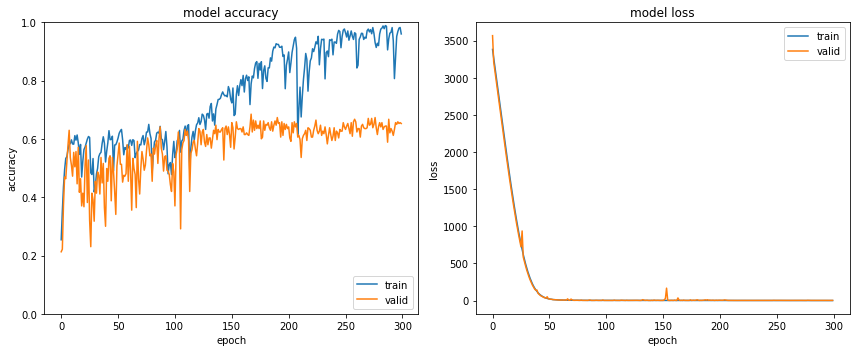

<Figure size 432x288 with 0 Axes>

In [23]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vi.history['accuracy'])
plt.plot(history_vi.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history_vi.history['loss'])
plt.plot(history_vi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.tight_layout()

plt.show()

plt.savefig(r'plots\bayesian_nn..jpg')

In [25]:
print("Evaluate on test data")
results = model_vi.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 1s 173ms/step - loss: 2.0093 - accuracy: 0.6671
test loss, test acc: [2.009336471557617, 0.6670507192611694]
